# Feature Engineering & Model's

## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import itertools


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Global Variables

In [2]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

In [3]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [5]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 24, falling back to string


In [6]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

In [7]:
df_input = (
    df
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"])) 
    .sort("DateOfReport")                                      
    .select([                                                 
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagingQuality"
    ])
)

### Target Variable

In [8]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality"])
y = df_pd["PackagingQuality"]

In [9]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

### Split dataset

In [10]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

## XGBoost

In [11]:
# Do this for both X_train and X_test
for col in categorical_features:
    if col in X_train.columns: # Check if column exists
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Define weights
class_weights = np.where(y_train == 1, 1, 4)  # Adjust the weight for the minority class

# Instantiate the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',  
    use_label_encoder=False,
    enable_categorical=True,
    tree_method='hist',
    n_estimators=1000, 
    learning_rate=0.05,
    random_state=42
)

# Train the model
model.fit(X_train, y_train, sample_weight=class_weights)

# Make predictions on the test set
y_pred_xgb = model.predict(X_test) 
y_proba_xgb = model.predict_proba(X_test)[:, 1] 

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### Evaluation

In [12]:
# Summary report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.68      0.41     28101
           1       0.88      0.61      0.72    114076

    accuracy                           0.62    142177
   macro avg       0.59      0.64      0.57    142177
weighted avg       0.77      0.62      0.66    142177



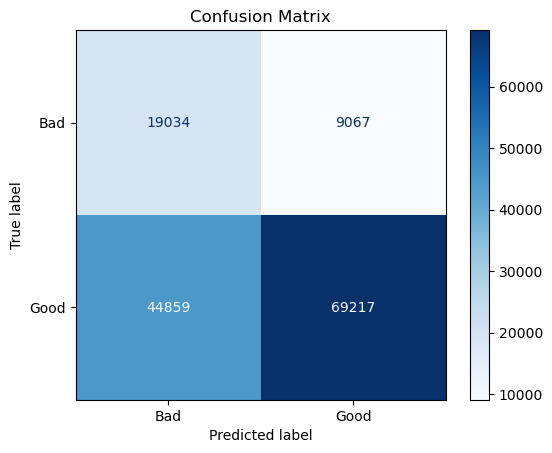

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6876


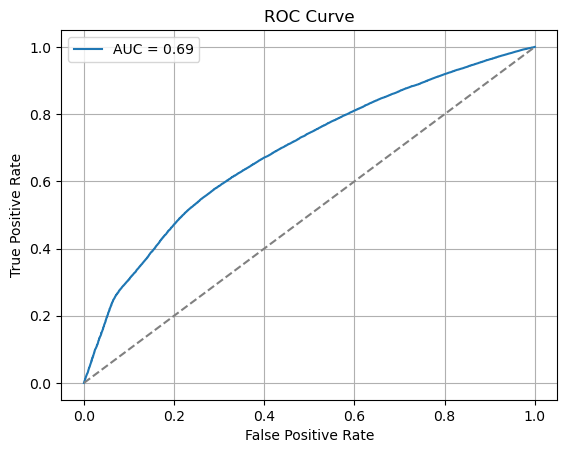

In [14]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
0,SupplierName,0.443736
2,Material,0.223808
3,Weight,0.058170
1,GarmentType,0.051183
7,Size,0.049225
8,Collection,0.047523
5,ProposedFoldingMethod,0.045780
6,ProposedLayout,0.040709
4,ProposedUnitsPerCarton,0.039866


## LightGBM

In [16]:
#weights
class_weights = np.where(y_train == 1, 1, 4)  


# Instantiate the LightGBM classifier
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

actual_categorical_in_train = [col for col in categorical_features if col in X_train.columns and X_train[col].dtype.name == 'category']

# Train the model
model_lgb.fit(X_train, y_train, sample_weight=class_weights,categorical_feature=actual_categorical_in_train)
# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]



[LightGBM] [Info] Number of positive: 266177, number of negative: 65569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 331746, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503691 -> initscore=0.014764
[LightGBM] [Info] Start training from score 0.014764


### Evaluation

In [17]:
#summary report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.68      0.41     28101
           1       0.88      0.61      0.72    114076

    accuracy                           0.62    142177
   macro avg       0.59      0.64      0.57    142177
weighted avg       0.77      0.62      0.66    142177



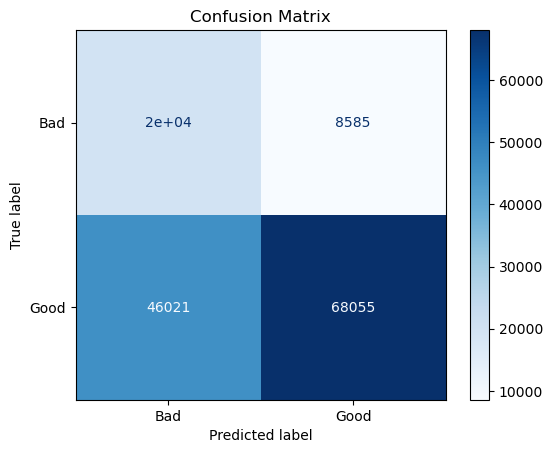

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6876


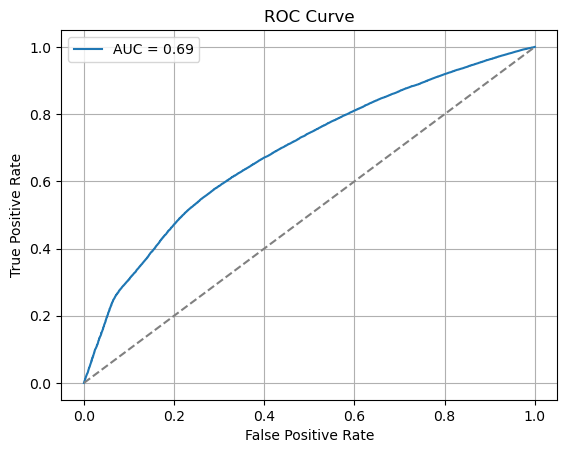

In [19]:
# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
3,Weight,8805
4,ProposedUnitsPerCarton,7971
0,SupplierName,3300
5,ProposedFoldingMethod,2819
7,Size,1790
2,Material,1529
1,GarmentType,1506
8,Collection,1415
6,ProposedLayout,865


## Prediction

### 1. Determine value ranges

#### 1.1 Categorical variables

In [21]:
categorical_columns = [
    "SupplierName",
    "GarmentType",
    "Material",
    "ProposedFoldingMethod",
    "ProposedLayout",
    "Size",
    "Collection"
]

# Build dictionary of distinct values
categorical_values_dict = {
    col: df_input.select(col).unique().sort(col).to_series().to_list()
    for col in categorical_columns
}

#### 1.2 Numerical variables

In [22]:
# Get min and max from df_input
min_weight = df_input.select("Weight").min().item()
max_weight = df_input.select("Weight").max().item()

min_units = df_input.select("ProposedUnitsPerCarton").min().item()
max_units = df_input.select("ProposedUnitsPerCarton").max().item()

# Create ranges dynamically
numerical_ranges = {
    "Weight": list(np.round(np.arange(min_weight, max_weight + 0.01, 0.01), 3)),
    "ProposedUnitsPerCarton": list(range(int(min_units), int(max_units) + 1))
}

### 2. Recommendation function

#### 2.1 Definition of the function

In [23]:
def recommend_best_packaging(fixed_inputs, model_lgb, top_n=1):
    # Define search space (only for variables you want to optimize)
    search_space = {
        "SupplierName": categorical_values_dict["SupplierName"],
        "ProposedUnitsPerCarton": numerical_ranges["ProposedUnitsPerCarton"],
        "ProposedFoldingMethod": categorical_values_dict["ProposedFoldingMethod"],
        "ProposedLayout": categorical_values_dict["ProposedLayout"]
    }

    # Generate Cartesian product
    keys = list(search_space.keys())
    values = list(search_space.values())
    grid_df = pd.DataFrame(itertools.product(*values), columns=keys)

    # Add fixed input columns
    for key, value in fixed_inputs.items():
        grid_df[key] = value

    # Reorder columns to match model input
    model_columns = ['SupplierName', 'GarmentType', 'Material', 'Weight',
                     'ProposedUnitsPerCarton', 'ProposedFoldingMethod',
                     'ProposedLayout', 'Size', 'Collection']
    grid_df = grid_df[model_columns]

    # Convert categorical columns to 'category' dtype for the model
    # categorical_features should be globally defined (e.g., from CELL 16)
    for col_name in categorical_features:
        if col_name in grid_df.columns:
            grid_df[col_name] = grid_df[col_name].astype('category')

    # Predict probabilities
    grid_df.loc[:, "prob_good"] = model.predict_proba(grid_df)[:, 1]

    # Return top N recommendations
    return grid_df.sort_values("prob_good", ascending=False).head(top_n)

#### 2.2 Test the recommendation

In [24]:
# Define the user input
fixed_inputs = {
    "GarmentType": "Shirt",
    "Material": "Cotton",
    "Weight": 1.00,
    "Size": "S",
    "Collection": "Winter"
}

# Apply the function
recommend_best_packaging(fixed_inputs, model_lgb)

,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,prob_good
4808,SupplierG,Shirt,Cotton,1.0,48,Method2,LayoutD,S,Winter,0.987169


## Stratification

In [25]:
# Configuration 
probability_class = 0
strata = {
    'labels': ['A', 'B', 'C', 'D', 'E'],
    'quantiles': [0, 0.05, 0.25, 0.75, 0.95, 1.0]
}

def assign_strata_using_probabilities(model_lgb, X_features, prob_class_idx, strata_config):
    if not hasattr(model_lgb, 'predict_proba'):
        raise ValueError("Model must have a predict_proba method.")
    if not isinstance(X_features, pd.DataFrame):
        raise ValueError("X_features must be a pandas DataFrame.")

    all_class_probabilities = model_lgb.predict_proba(X_features)
    selected_probabilities = all_class_probabilities[:, prob_class_idx]

    df_with_strata = X_features.copy()
    df_with_strata['probability_of_interest'] = selected_probabilities

    try:
        df_with_strata['prediction_stratum'] = pd.qcut(
            df_with_strata['probability_of_interest'],
            q=strata_config['quantiles'],
            labels=strata_config['labels'],
            duplicates='drop'
        )
    except Exception: 
        df_with_strata['prediction_stratum'] = np.nan
    return df_with_strata


if 'model_lgb' in locals() and 'X_test' in locals() and isinstance(X_test, pd.DataFrame):
    stratified_test_df = assign_strata_using_probabilities(
        model_lgb,
        X_test,
        prob_class_idx=probability_class,
        strata_config=strata
    )

    # Print strata counts and percentages if stratification was successful
    if not stratified_test_df['prediction_stratum'].isnull().all():
        print("Stratum Distribution (Count, %):")
        strata_counts_actual = stratified_test_df['prediction_stratum'].value_counts().sort_index()
        strata_counts_percentage = stratified_test_df['prediction_stratum'].value_counts(normalize=True).sort_index() * 100

        for stratum_label in strata['labels']:
            if stratum_label in strata_counts_actual:
                print(f"  {stratum_label}: {strata_counts_actual[stratum_label]} ({strata_counts_percentage[stratum_label]:.2f}%)")
            else:
                print(f"  {stratum_label}: 0 (0.00%)")
        print(f"Total Stratified: {stratified_test_df.shape[0]} (Original X_test size: {X_test.shape[0]})")
    else:
        print("Stratification failed or resulted in all NaNs for 'prediction_stratum'.")
        print(f"Original X_test size: {X_test.shape[0]}") 

else:
    print("Execution skipped: Required variables ('model_lgb', 'X_test') not found or X_test is not a DataFrame.")

Stratum Distribution (Count, %):
  A: 7109 (5.00%)
  B: 28436 (20.00%)
  C: 71088 (50.00%)
  D: 28435 (20.00%)
  E: 7109 (5.00%)
Total Stratified: 142177 (Original X_test size: 142177)


### EDA of each strata

In [26]:
# filter by stratum
strat_a = stratified_test_df[stratified_test_df["prediction_stratum"] == "A"]
strat_b = stratified_test_df[stratified_test_df["prediction_stratum"] == "B"]
strat_c = stratified_test_df[stratified_test_df["prediction_stratum"] == "C"]
strat_d = stratified_test_df[stratified_test_df["prediction_stratum"] == "D"]
strat_e = stratified_test_df[stratified_test_df["prediction_stratum"] == "E"]


#### Stratum A

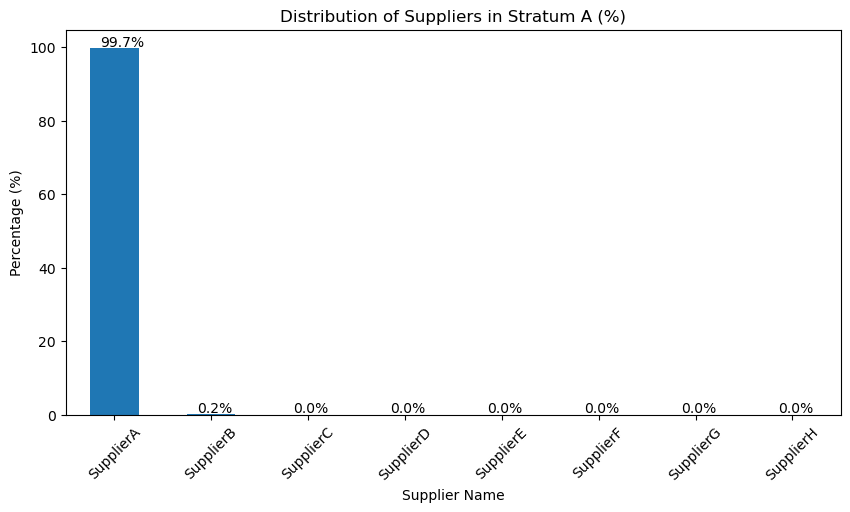

In [27]:
#distribution of supplier in strat_a in percentage
ax = (strat_a["SupplierName"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Suppliers in Stratum A (%)")
plt.xlabel("Supplier Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()


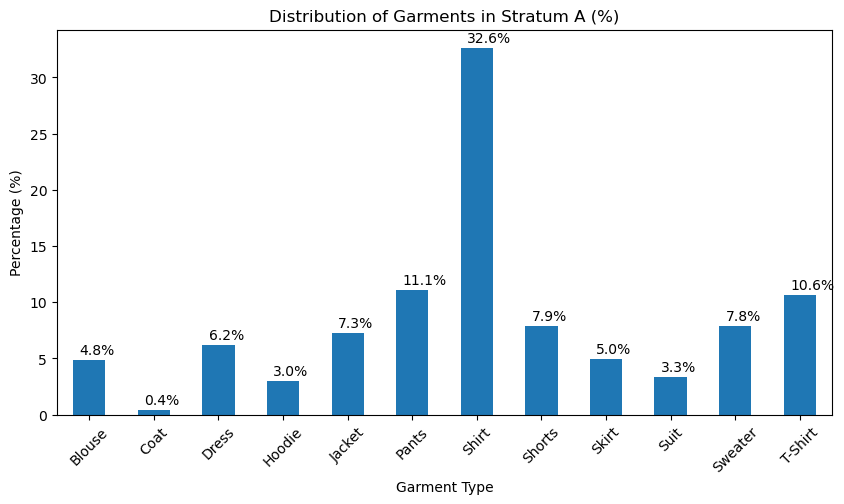

In [28]:
#distribution of GarmentType in strat_a in percentage
ax = (strat_a["GarmentType"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Garments in Stratum A (%)")
plt.xlabel("Garment Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()

#### Stratum B

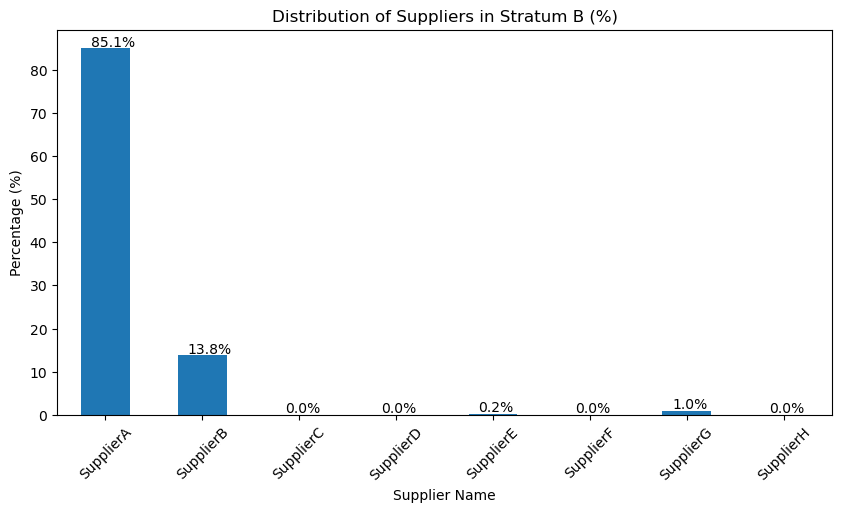

In [29]:
#distribution of supplier in strat_b in percentage
ax = (strat_b["SupplierName"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Suppliers in Stratum B (%)")
plt.xlabel("Supplier Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()



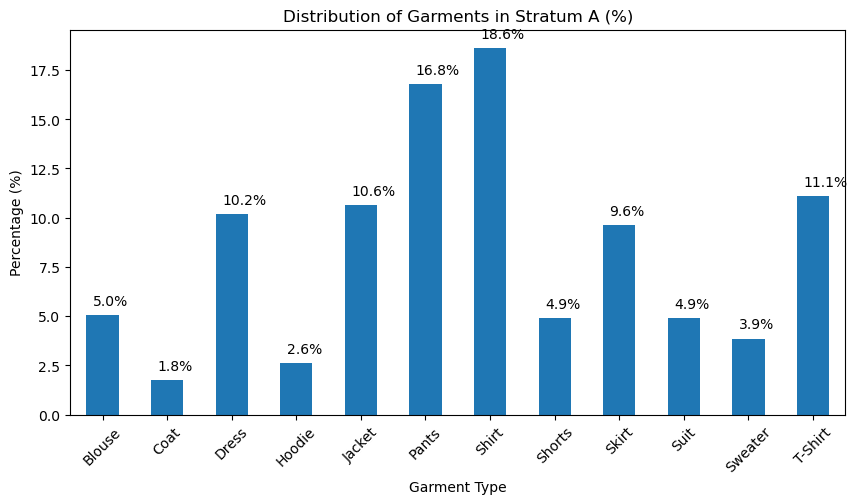

In [30]:
#distribution of GarmentType in strat_b in percentage
ax = (strat_b["GarmentType"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Garments in Stratum A (%)")
plt.xlabel("Garment Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()

#### Stratum C

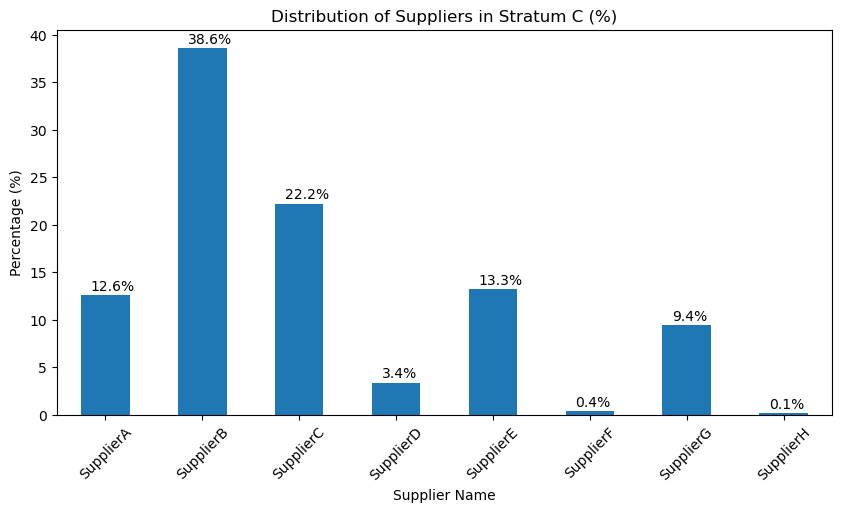

In [31]:
#distribution of supplier in strat_c in percentage
ax = (strat_c["SupplierName"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Suppliers in Stratum C (%)")
plt.xlabel("Supplier Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()



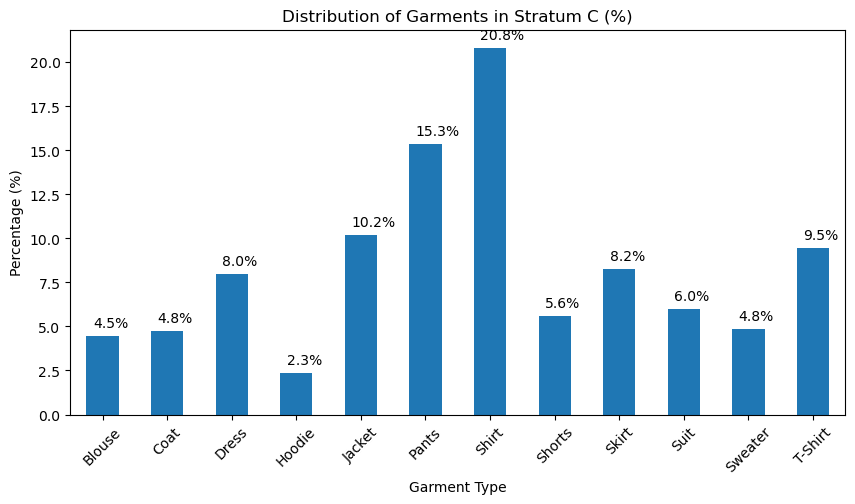

In [32]:
#distribution of GarmentType in strat_c in percentage
ax = (strat_c["GarmentType"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Garments in Stratum C (%)")
plt.xlabel("Garment Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()

#### Stratum D

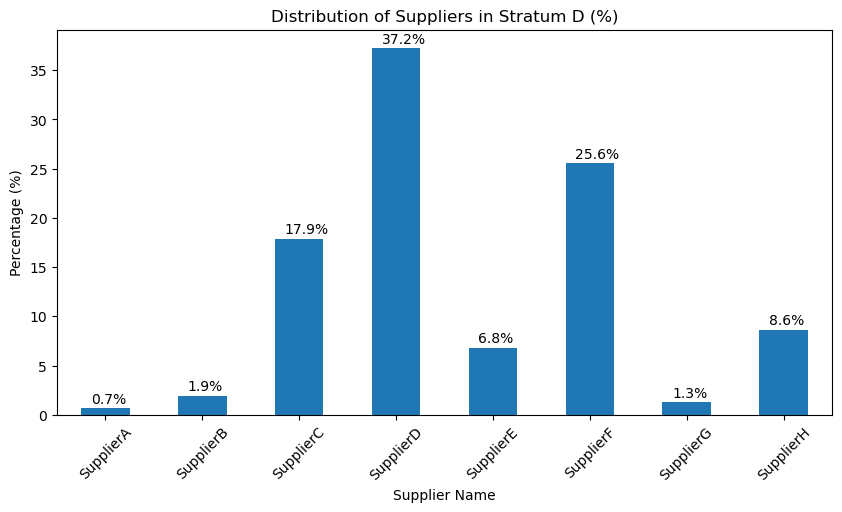

In [33]:
#distribution of supplier in strat_d in percentage
ax = (strat_d["SupplierName"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Suppliers in Stratum D (%)")
plt.xlabel("Supplier Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()



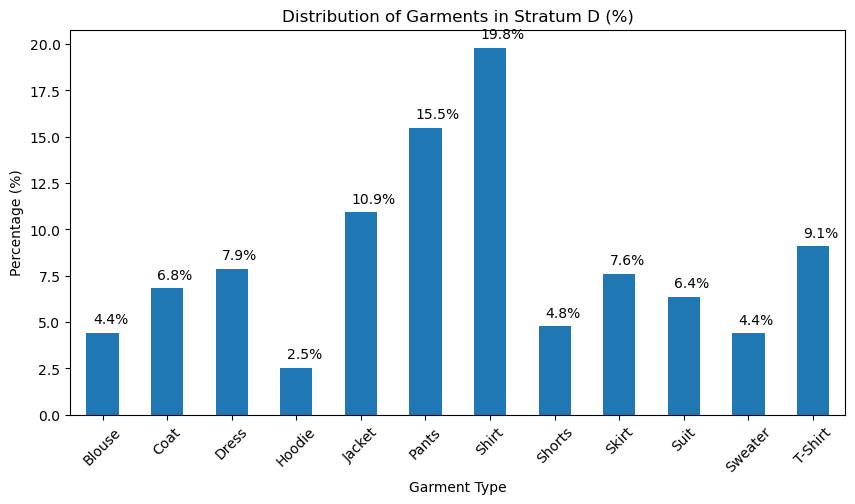

In [34]:
#distribution of GarmentType in strat_d in percentage
ax = (strat_d["GarmentType"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Garments in Stratum D (%)")
plt.xlabel("Garment Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()

#### Stratum E

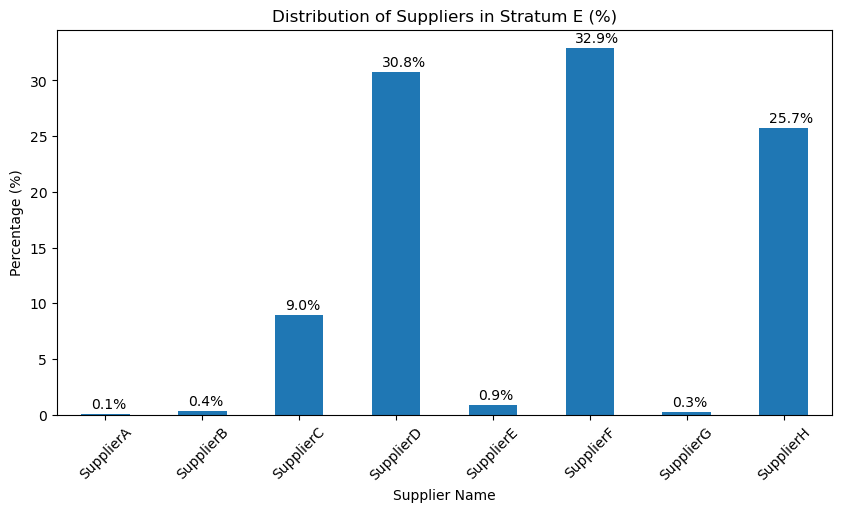

In [35]:
#distribution of supplier in strat_e in percentage
ax = (strat_e["SupplierName"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Suppliers in Stratum E (%)")
plt.xlabel("Supplier Name")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()



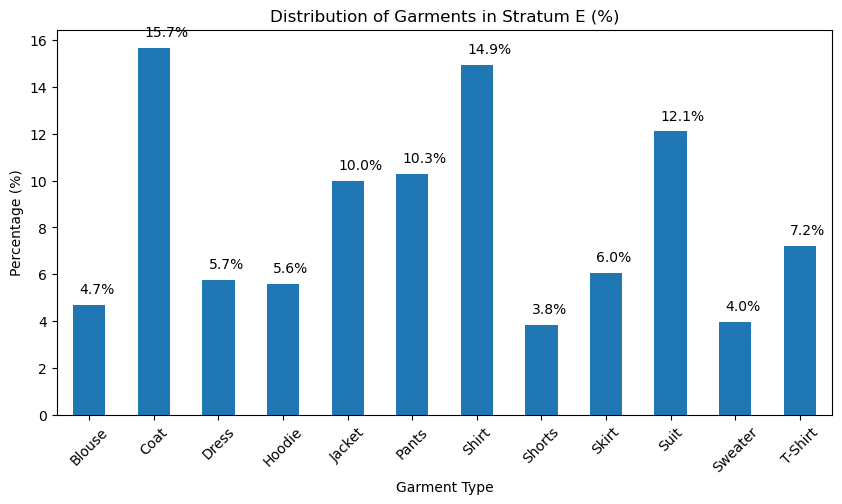

In [36]:
#distribution of GarmentType in strat_e in percentage
ax = (strat_e["GarmentType"].value_counts(normalize=True).sort_index() * 100).plot(kind="bar", figsize=(10, 5), title="Distribution of Garments in Stratum E (%)")
plt.xlabel("Garment Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)

# Add percentage labels to each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.15 # Adjust x position for centering
    y = p.get_height() + 0.5 # Adjust y position to be slightly above the bar
    ax.annotate(percentage, (x, y))

plt.show()

## Export the model